# Preamble

In [1]:
import pandas as pd
import numpy as np
import scipy, sklearn, os, sys, string, fileinput, glob, re, math, itertools, functools, copy, pickle
import scipy.stats, sklearn.decomposition, sklearn.preprocessing, sklearn.covariance
from scipy.stats import describe
import scipy.sparse
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
plt.rcParams["figure.figsize"]= (12,8)
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import scanpy as sc
    import scvelo as scv
    from anndata import AnnData
    
from collections import defaultdict

%load_ext autoreload
%autoreload 1

In [2]:
sys.path.append('/afs/csail.mit.edu/u/r/rsingh/work/schema/schema')

In [3]:
import schema_qp

In [4]:
from umap import UMAP
from sklearn.manifold import TSNE

# Helper Funcs

In [5]:
DEBUG_MODE=True #False #True

def dbg_print(s, *args, **kwargs):
    if DEBUG_MODE or s[:5] != "Flag ":
        print(s, *args, **kwargs)

def do_scanpy_processing_and_filtering(adata, sample_frac=1.0, do_log1p=True):
    import scanpy as sc

    if sample_frac > 0.999:
        sample_n = int(adata.shape[0]* float(sample_frac))
        sample_idxs = np.random.choice(adata.shape[0], sample_n, replace=False)
        adata2 = adata[sample_idxs].copy()
    else:
        adata2 = adata.copy()
    dbg_print("Flag 123.10 ", adata.shape, adata2.shape, sample_frac)

    cinfo, _ = sc.pp.calculate_qc_metrics(adata2, inplace=False)
    c2depth_thresh = sorted(cinfo["total_counts"])[max(10,int(0.001*adata2.shape[0]))]
    c2gcnt_thresh = sorted(cinfo["n_genes_by_counts"])[max(10,int(0.001*adata2.shape[0]))]
    dbg_print("Flag 123.20 ", c2depth_thresh, c2gcnt_thresh)

    sc.pp.filter_cells(adata2, min_counts = c2depth_thresh+1)
    sc.pp.filter_cells(adata2, min_genes = c2gcnt_thresh+1)
    sc.pp.normalize_total(adata2, target_sum=1e6)
    if do_log1p:
        sc.pp.log1p(adata2)
    dbg_print("Flag 123.40 ", adata2.shape)
    return adata2


In [6]:
def plt2(m1,m2,s,datax,cidx=None):
    df1 = datax.obs.clusters.to_frame()
    df1["codes"] = df1.iloc[:,0].astype('category').cat.codes
    dmap = dict(df1.values.tolist())
    markersize=1
    fig, ax = plt.subplots(1,2,figsize=(18,6)) #(12,4))
    #print(dmap)
    for g in np.unique(df1.iloc[:,0]):
        ix = (df1.iloc[:,0] == g).values
        #print(g, len(ix), sum(ix))
        if cidx is None:
            ax[0].scatter(m1[ix,:][:,0], m1[ix,:][:,1], label=g, s = markersize)
            ax[1].scatter(m2[ix,:][:,0], m2[ix,:][:,1], label=g, s = markersize)
        else:
            ax[0].scatter(m1[ix,:][:,0], m1[ix,:][:,1], c=cidx[ix], vmin=0, vmax=1, cmap='gnuplot', s = markersize)
            ax[1].scatter(m2[ix,:][:,0], m2[ix,:][:,1], c=cidx[ix], vmin=0, vmax=1, cmap='gnuplot', s = markersize)            
    for g in np.unique(df1.iloc[:,0]):
        ix = (df1.iloc[:,0] == g).values
        mu1 = np.mean(m1[ix,:],axis=0)
        mu2 = np.mean(m2[ix,:],axis=0)
        ax[0].text(mu1[0], mu1[1], g)
        ax[1].text(mu2[0], mu2[1], g)
    #ax[0].legend()
    #ax[1].legend()
    ax[0].set_title("UMAP:" + s, pad=-10)
    ax[1].set_title("TSNE:" + s, pad=-10)
    for a in ax:
        a.get_xaxis().set_ticks([])
        a.get_yaxis().set_ticks([])
        #a.axis('off')


In [7]:
def get_cell_clusters():
    df1 = bdata2s.obs.clusters.to_frame()
    df1["codes"] = df1.iloc[:,0].astype('category').cat.codes
    L = []
    for g in np.unique(df1.iloc[:,0]):
        ix = (df1.iloc[:,0] == g).values
        L.append((g,ix))
    return L



In [8]:
def f_umap(m): #umap via scanpy. Their settings are "better" than default umap's
    xdata = AnnData(X = m)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")    
        sc.pp.neighbors(xdata)
        sc.tl.umap(xdata)
    return xdata.obsm['X_umap']

def f_tsne(m):
    t = TSNE(init='pca', random_state=0)
    return t.fit_transform(m)
    #return fast_tsne(m)


In [9]:
def plot_tsne(m, s, cidx=None, outfile=None):
    L = get_cell_clusters()
    datax = bdata2s
    markersize=1
    
    fig = plt.figure(figsize=(9,6))
    ax = fig.gca()
    for g, ix in L:
        if cidx is None:
            sctr = ax.scatter(m[ix,:][:,0], m[ix,:][:,1], label=g, s = markersize)
        else:
            sctr = ax.scatter(m[ix,:][:,0], m[ix,:][:,1], c=cidx[ix], vmin=0, vmax=1, cmap='gnuplot', s = markersize)            
        mu = np.mean(m[ix,:],axis=0)
        ax.text(mu[0], mu[1], g)
        
    if cidx is not None:
        sctr.set_clim([0, 1])
        colorbar = fig.colorbar(sctr, ax=ax)

    ax.axis('off')
    ax.set_title(s, pad=-10)

    if outfile is not None:
        fig.savefig(outfile)
    return fig

# Dentate Gyrus

## Data Load


In [10]:
bdata1 = scv.datasets.dentategyrus()

bdata2s= do_scanpy_processing_and_filtering(bdata1)
bdata2u = bdata2s.copy()
bdata2u.X = bdata2s.layers['unspliced']
sc.pp.normalize_total(bdata2u, target_sum=1e6)
sc.pp.log1p(bdata2u)

Flag 123.10  (2930, 13913) (2930, 13913) 1.0
Flag 123.20  1056.0 602
Flag 123.40  (2909, 13913)


In [11]:
bdata1.shape

(2930, 13913)

#### Also do scVelo's RNA velocity processing

In [12]:
sc.pp.neighbors(bdata2s)
scv.tl.velocity_graph(bdata2s)
scv.tl.velocity_pseudotime(bdata2s)

         Falling back to preprocessing with `sc.pp.pca` and default params.
Normalized count data: spliced.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:14) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 3 regions of root cells and 4 regions of end points 
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


In [13]:
bdata2s.shape, bdata2u.shape

((2909, 13913), (2909, 13913))

## Run Schema:  primary dataset is spliced, secondary is unspliced


##### PCA on spliced and unspliced data

In [14]:
pcadim=100
pca = sklearn.decomposition.PCA(pcadim, random_state=0)
Ms = pca.fit_transform(bdata2s.X.todense())

pca = sklearn.decomposition.PCA(pcadim, random_state=0)
Mus = pca.fit_transform(bdata2u.X.todense())

#### Run Schema

In [15]:
import schema_qp
dS = {}
for i, mc in enumerate([0.9, 0.95, 0.99]): 
    sqp = schema_qp.SchemaQP(mc, mode="scale")
    Xs = sqp.fit_transform(Ms, [Mus], ['feature_vector'], [1])
    dS[mc] = (Xs, sqp)
dS[1] = (Ms, None)

Flag 456.10   1000
Running quadratic program...INFO:  Flag 102.30  (2909, 100) [array([[ 10.606441  ,  -4.752916  ,  -3.627634  , ...,   4.380918  ,
         -3.874067  ,   7.2689314 ],
       [ 19.224655  ,  -0.53531945,   6.228919  , ...,   3.2605488 ,
          6.0051703 ,   4.0799026 ],
       [ 16.91843   ,  -6.717768  ,   0.1853475 , ...,   0.6553323 ,
          1.4371064 ,   1.5991235 ],
       ...,
       [ 17.294071  , -10.719605  ,  -3.2009788 , ...,   3.0619416 ,
          1.1492581 ,   2.6666515 ],
       [-39.529434  ,  -4.5584207 ,   4.5392213 , ...,  -0.6359956 ,
          2.600168  ,  -4.369415  ],
       [ 21.0781    ,  -8.025865  ,   1.3396683 , ...,  -4.984723  ,
         -2.9699252 ,  -1.1655017 ]], dtype=float32)] ['feature_vector'] [1]
INFO:  Flag 102.35  (2909, 100) [array([[ 10.606441  ,  -4.752916  ,  -3.627634  , ...,   4.380918  ,
         -3.874067  ,   7.2689314 ],
       [ 19.224655  ,  -0.53531945,   6.228919  , ...,   3.2605488 ,
          6.0051703 ,   

#### Estimate Pseudotime
 We compute the expression vector representing the difference of new and old RNAseq representation and then compute the projection of each cell along it. The length of the projection is the pseudotime estimate. 

In [78]:
def rownorm(m):
    return m/np.sqrt(1e-14 + np.sum(m**2,axis=1))[:,None]

qS = {}
scv_lt = bdata2s.obs.velocity_pseudotime.values
l =  [(0, (Mus, None))] + list(sorted(dS.items())) 
for mc, (X,_) in l: #sorted(dS.items()):
    print(Ms.shape, Mus.shape, X.shape)
    
    Mdiff = np.mean(rownorm(Ms-X),axis=0)
    pc1 = np.sum(rownorm(Ms)*Mdiff, axis=1)
    
    idx1 = np.isfinite(scv_lt) 
    tau1, rho1 = scipy.stats.spearmanr(pc1[idx1], scv_lt[idx1]), scipy.stats.pearsonr(pc1[idx1], scv_lt[idx1]) 
    print(mc, [(abs(a[0]),a[1]) for a in [tau1, rho1]])
    qS[mc] = (pc1, tau1, rho1)


(2909, 100) (2909, 100) (2909, 100)
0 [(0.31454323555681807, 8.080865275573478e-68), (0.12239882318644053, 3.50366558892405e-11)]
(2909, 100) (2909, 100) (2909, 100)
0.9 [(0.4157935119668362, 5.410020495833554e-122), (0.13945224778477155, 4.185793167790852e-14)]
(2909, 100) (2909, 100) (2909, 100)
0.95 [(0.4254066040622498, 3.321819814250637e-128), (0.06203814890979523, 0.0008144886910327915)]
(2909, 100) (2909, 100) (2909, 100)
0.99 [(0.7156756406003154, 0.0), (0.7791806728217133, 0.0)]
(2909, 100) (2909, 100) (2909, 100)
1 [(nan, nan), (nan, nan)]


In [80]:
np.finfo(np.float64)

finfo(resolution=1e-15, min=-1.7976931348623157e+308, max=1.7976931348623157e+308, dtype=float64)

# Figures

In [17]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

outdir="/afs/csail.mit.edu/u/r/rsingh/work/schema/data/rna_velocity/figs/"

#### Pseudotime

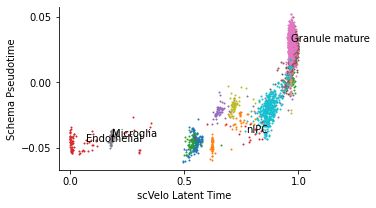

In [18]:
scv_ptime = bdata2s.obs.velocity_pseudotime
schema_ptime = qS[0.99][0]

L = get_cell_clusters()
idx = np.isfinite(scv_lt)

fig = plt.figure(figsize=(4.5,3)) #(3,4.5))
ax = fig.gca()
for g, ix in L:
    #ax.scatter(schema_ptime[ix & idx], scv_ptime[ix & idx], label=g, s = 1)
    ax.scatter(scv_ptime[ix & idx], schema_ptime[ix & idx], label=g, s = 1)
    if g not in ['nIPC', 'Microglia', 'Endothelial', 'Granule mature']: continue # print only a few names to avoid clutter
    mux = np.mean(schema_ptime[idx & ix])
    muy = np.mean(scv_ptime[idx & ix])
    #ax.text(mux, muy, g)
    ax.text(muy, mux, g)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.get_xaxis().set_ticks([-0.05, 0, 0.05])
# ax.get_yaxis().set_ticks([0, 0.5, 1])
# ax.set_xlabel('Schema Pseudotime')
# ax.set_ylabel('scVelo Latent Time')
ax.get_xaxis().set_ticks([0, 0.5, 1])
ax.get_yaxis().set_ticks([-0.05, 0, 0.05])
ax.set_xlabel('scVelo Latent Time')
ax.set_ylabel('Schema Pseudotime')
fig.savefig(outdir + "ptime_compare_horizontal.pdf")

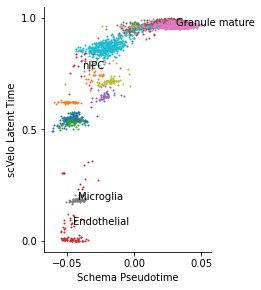

In [77]:
scv_ptime = bdata2s.obs.velocity_pseudotime
schema_ptime = qS[0.99][0]

L = get_cell_clusters()
idx = np.isfinite(scv_lt)

fig = plt.figure(figsize=(3,4.5))
ax = fig.gca()
for g, ix in L:
    ax.scatter(schema_ptime[ix & idx], scv_ptime[ix & idx], label=g, s = 1)
    #ax.scatter(scv_ptime[ix & idx], schema_ptime[ix & idx], label=g, s = 1)
    if g not in ['nIPC', 'Microglia', 'Endothelial', 'Granule mature']: continue # print only a few names to avoid clutter
    mux = np.mean(schema_ptime[idx & ix])
    muy = np.mean(scv_ptime[idx & ix])
    ax.text(mux, muy, g)
    #ax.text(muy, mux, g)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().set_ticks([-0.05, 0, 0.05])
ax.get_yaxis().set_ticks([0, 0.5, 1])
ax.set_xlabel('Schema Pseudotime')
ax.set_ylabel('scVelo Latent Time')
# ax.get_xaxis().set_ticks([0, 0.5, 1])
# ax.get_yaxis().set_ticks([-0.05, 0, 0.05])
# ax.set_xlabel('scVelo Latent Time')
# ax.set_ylabel('Schema Pseudotime')
# fig.savefig(outdir + "ptime_compare_horizontal.pdf")
fig.savefig(outdir + "ptime_compare_vertical.pdf")

#### Embeddings

0.9
0.95
0.99
1.0


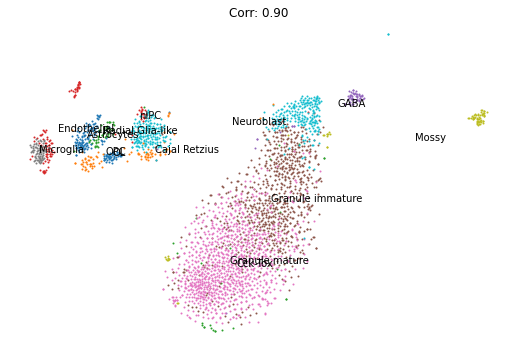

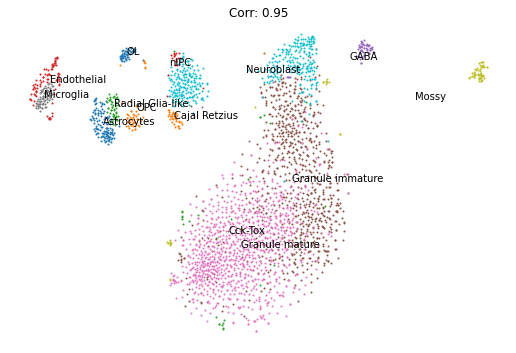

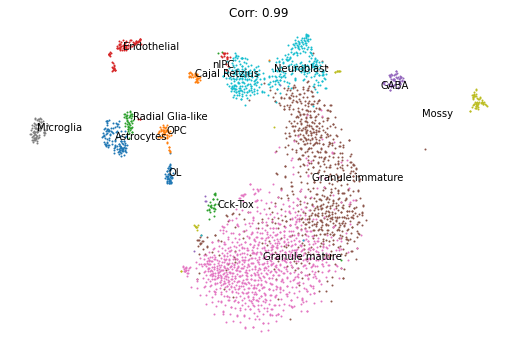

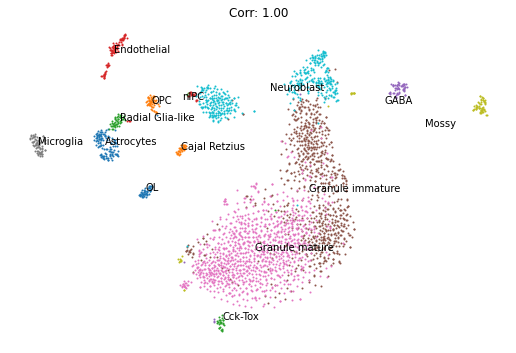

In [20]:
pD = {}
for mc in [0.95, 0.99, 1.0]:
    print(mc)
    x_t = f_tsne(dS[mc][0])
    pD[mc] = x_t
    plot_tsne(x_t, "Corr: %.2f"%(mc), None, "base_tsne_corr%.2f.pdf"%(mc) )
    
# for mc in [0.9, 0.95, 0.99, 1.0]:
#     print(mc)
#     x_t = pD[mc]
#     plot_tsne(x_t, "Corr: %.2f"%(mc), None, outdir+"base_tsne_corr%.2f.pdf"%(mc) )

#### Embeddings colored by scVelo Latent Time

0.95
0.99
1.0


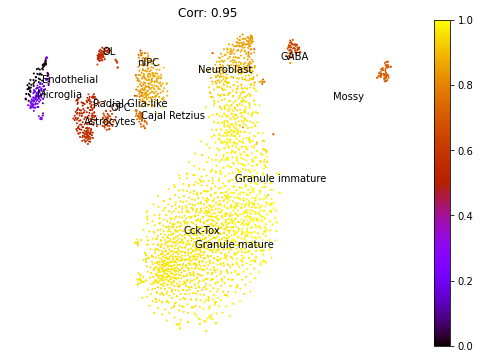

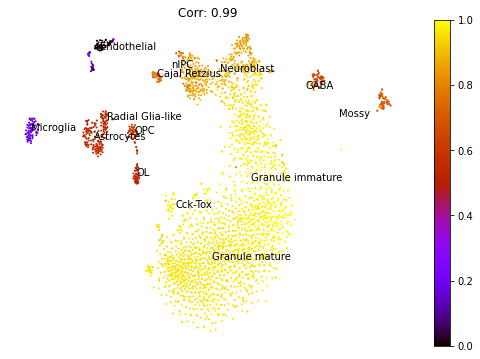

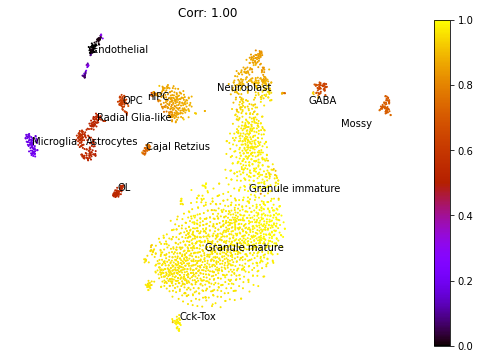

In [59]:
for mc in [0.95, 0.99, 1.0]:
    print(mc)
    x_t = pD[mc]
    plot_tsne(x_t, "Corr: %.2f"%(mc), cidx=bdata2s.obs.velocity_pseudotime, outfile=outdir+"latenttime_colored_tsne_corr%.2f.pdf"%(mc) )

#### Distance correlation in the embedding space against scVelo Latent Time

In [57]:
def get_class_balanced_indices():
    w0 = bdata2s.obs.clusters.value_counts().to_frame().reset_index().rename(columns={'index':'clusters','clusters':'freq'})
    w0["wt"] = 1/w0["freq"]

    ydf = bdata2s.obs
    ydf["ridx"] = range(ydf.shape[0])
    ydf = pd.merge(ydf, w0).sort_values('ridx').reset_index(drop=True)
    ydf["wt"] = ydf["wt"]/ydf["wt"].sum()
    yidx = np.random.choice(ydf.shape[0], 2*ydf.shape[0], True, ydf.wt)
    return yidx

In [90]:
yidx = get_class_balanced_indices()
for mc in [0.95, 0.99, 1.0]:
    u,v = scipy.spatial.distance.pdist(pD[mc][yidx,:]), scipy.spatial.distance.pdist(bdata2s.obs.velocity_pseudotime.values[yidx,None])
    print(mc, scipy.stats.pearsonr(u,v)[0], scipy.stats.spearmanr(u,v)[0])

u,v = scipy.spatial.distance.pdist(x_c[yidx,:]), scipy.spatial.distance.pdist(bdata2s.obs.velocity_pseudotime.values[yidx,None])
print("CCA", scipy.stats.pearsonr(u,v)[0], scipy.stats.spearmanr(u,v)[0])

0.95 0.38356035958649637 0.4317078590588127
0.99 0.35407233645634234 0.39964354333651814
1.0 0.34614472824383213 0.3966114884911531
CCA 0.15188716409461697 0.16287710829379018


In [88]:
u = scipy.stats.rankdata(scipy.spatial.distance.pdist(pD[0.99][yidx,:])) - scipy.stats.rankdata(scipy.spatial.distance.pdist(pD[1.0][yidx,:]))
print("0.99-vs-1.0", scipy.stats.pearsonr(u,v), scipy.stats.spearmanr(u,scipy.stats.rankdata(v)))

0.99-vs-1.0 (-0.002943621993394445, 9.47677123955895e-34) SpearmanrResult(correlation=0.09318854000499167, pvalue=0.0)


#### Get scVelo Velocity Embedding Stream

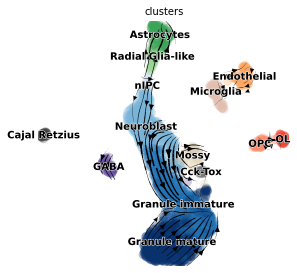

In [82]:
fig = plt.figure(figsize=(4.5,4.5))
ax = fig.gca()
scv.pl.velocity_embedding_stream(bdata2s, basis='umap', color=['clusters'], ax=ax)
ax.axis('off')
ax.set_xlabel('scVelo Velocity Streamplot')
fig.savefig(outdir + "scvelo_velocity_streamplot.png")

#### CCA

In [83]:
from sklearn.cross_decomposition import CCA
cca = CCA(n_components=30)
cca.fit(Ms, Mus)

CCA(n_components=30)

In [84]:
x_c = f_tsne(cca.x_scores_)

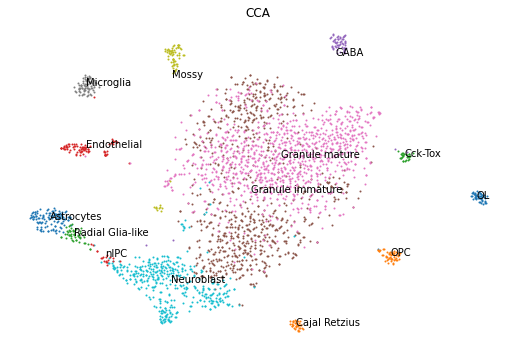

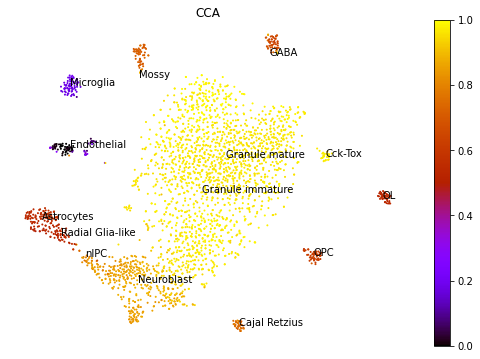

In [85]:
plot_tsne(x_c, "CCA", None, outfile=outdir+"tsne_CCA.pdf");
plot_tsne(x_c, "CCA", cidx=bdata2s.obs.velocity_pseudotime, outfile=outdir+"latenttime_colored_tsne_CCA.pdf");